Library Imports

In [146]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

Logic

In [147]:
#code for reading file
def readf(file):
    f = open(file, encoding="utf-8")
    data = list(csv.reader(f))
    f.close()
    return data

In [148]:
#code for formatting deficiency_code
def padding(defcode):
    defcode = str(defcode)
    if len(defcode) < 5:
        defcode = "0" + defcode
    return defcode

In [149]:
scores = {}
count = {}
average = {}
conversion = {"Not a deficiency": 0, "Low": 1, "Medium": 2, "High": 3}
data = readf("psc_severity_train.csv")
print(data[5015][4])
for row in data[1:]:
    defcode = padding(row[1])
    if row[4] != '':
        if defcode not in scores:
            count[defcode] = 1
            scores[defcode] = conversion[row[4]]

        else:
            count[defcode] += 1
            scores[defcode] += conversion[row[4]]
for defcode in scores:
    average[defcode] = round(scores[defcode]/count[defcode],3)
print(scores)
print(count)
print(average)

Low
{'01104': 36, '10135': 117, '10136': 82, '10137': 25, '01201': 67, '10138': 83, '10199': 47, '11101': 259, '11102': 82, '11103': 63, '01202': 33, '11104': 173, '11105': 115, '11106': 42, '11107': 69, '11108': 118, '11110': 90, '11112': 130, '11113': 143, '01209': 44, '11116': 62, '11117': 158, '11118': 63, '11119': 86, '11122': 47, '11123': 47, '11124': 99, '11125': 58, '11126': 55, '11127': 26, '11128': 51, '11129': 94, '01213': 32, '11131': 115, '11132': 67, '11134': 83, '11135': 54, '11199': 55, '12101': 41, '12104': 18, '12106': 52, '12107': 55, '12108': 70, '01214': 58, '12199': 30, '13101': 239, '13102': 181, '13103': 191, '13104': 103, '13105': 75, '13106': 80, '13107': 23, '01215': 29, '13108': 98, '13199': 205, '14101': 40, '14102': 78, '14104': 119, '14105': 110, '14107': 85, '14108': 152, '14110': 45, '14119': 70, '14121': 48, '14122': 34, '14199': 121, '01218': 48, '14302': 34, '14304': 32, '14402': 134, '14403': 32, '14404': 67, '14499': 74, '14501': 98, '14502': 32, '

Charting

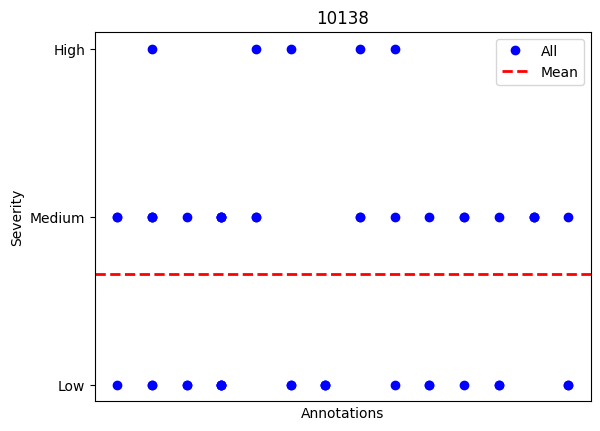

In [150]:
# charting
input_code = input("Enter code: ")

x = []
y = []

for row in data[1:]:
    if padding(input_code) == row[1]:
        x.append(row[0])
        y.append(conversion[row[4]])

# Create the plot
plt.plot(x, y, marker='o', linestyle='', color='b', label='All')
plt.axhline(y=average[padding(input_code)], color='r', linestyle='--', linewidth=2, label='Mean')

plt.xticks([])
tick_positions = [1, 2, 3]  # Custom positions
tick_labels = ['Low', 'Medium', 'High']  # Custom labels
plt.yticks(tick_positions, tick_labels)

# Add labels and title
plt.xlabel('Annotations')
plt.ylabel('Severity')
plt.title(input_code)

# Show the legend
plt.legend()

# Display the chart
plt.show()

In [ ]:

df = pd.read_csv('psc_severity_train.csv')
# Maps all highs to 3, meds to 2, lows to 1 
df['annotation_severity'] = df['annotation_severity'].map(conversion)
# Groups all deficiency codes into one place and finds mean severity rate for each deficiency code
meandf = df.groupby("deficiency_code")["annotation_severity"].mean()
# finds median severity rate for each deficiency code
mediandf = df.groupby("deficiency_code")["annotation_severity"].median()
# finds statistics summary for each deficiency code
describedf = df.groupby("deficiency_code")["annotation_severity"].describe()
print(describedf)